In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import spacy
import en_core_web_md
import csv
import regex as re
import os

<A HREF="https://pandas.pydata.org/Pandas_Cheat_Sheet.pdf">Pandas cheat sheet</A>

In [47]:
file='speech_and_date.csv'
dates=pd.read_csv(file)
dates['date'][23]


'10/05/2010'

In [72]:
# use .iloc[0] to get the actual string in the cell and not a pandas object
dates.loc[dates['date'] == '27/01/2010']['file'].iloc[0]

'DataUCSB/address-before-joint-session-the-congress-the-state-the-union-17.txt'

In [83]:
# use .iloc[0] to get the actual string in the cell and not a pandas object
speechlink = dates.loc[dates['date'] == '27/01/2010']['file'].iloc[0]
with open(speechlink, encoding='utf-8') as f:
        spec_speech = f.read()
spec_speech=re.sub('\[.+?\]', '',spec_speech)
spec_speech=re.sub('\-\-', ' ',spec_speech)

In [81]:
nytimesFile="./NYTimes/01-27-2010.txt"
with open(nytimesFile, encoding='utf-8') as f:
        nytimes = f.read()
nytimes = nytimes.replace('\n', '')

In [9]:
# Load up the files
path = './DataUCSB/'
list_of_files = []

for root, dirs, files in os.walk(path):
    for file in files:
        if file.endswith('.txt'):
            list_of_files.append(os.path.join(root,file))

filepath = './DataUCSB/address-before-joint-session-the-congress-the-state-the-union-16.csv'
speeches = []
for file in list_of_files:
    with open(file, encoding='utf-8') as f:
        text = f.read()
    speeches.append(text)

<A HREF="https://regexr.com/">Regexr</A>

In [10]:
# take out stuff like [Laughter] and [applause] and [Obama signs document]
speeches = [re.sub('\[.+?\]', '',speech) for speech in speeches]
# take out -- between words and replace with a space
speeches = [re.sub('\-\-', ' ',speech) for speech in speeches]

Just looking at the one specific Obama speech vs NYTimes article here, not all

In [84]:
speechlist_ob = [sentence.lstrip().rstrip() for sentence in spec_speech.split('.')]
lengthsob = [len(sentence.split(' ')) for sentence in speechlist_ob]

Rem: NYTimes article is filled with many quotes from Obama's speech

In [85]:
speechlist_ny = [sentence.lstrip().rstrip() for sentence in nytimes.split('.')]
lengthsny = [len(sentence.split(' ')) for sentence in speechlist_ny]

<A HREF="https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.plot.html">Matplotlib docs</A>

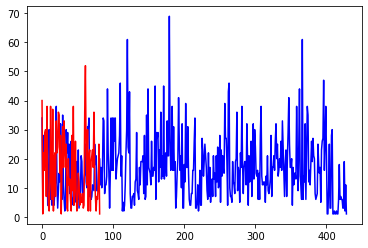

In [86]:
plt.plot(lengthsob, 'b')
plt.plot(lengthsny, 'r')
plt.show()

In [89]:
print('Obama: mean %s and stdev %s' %(round(np.average(lengthsob),3), round(np.std(lengthsob),3)))

Obama: mean 16.888 and stdev 10.962


In [90]:
print('NYTines: mean %s and stdev %s' %(round(np.average(lengthsny),3), round(np.std(lengthsny),3)))

NYTines: mean 16.561 and stdev 12.211


<A HREF="https://matplotlib.org/stable/gallery/statistics/hist.html">Matplotlib histograms</A>

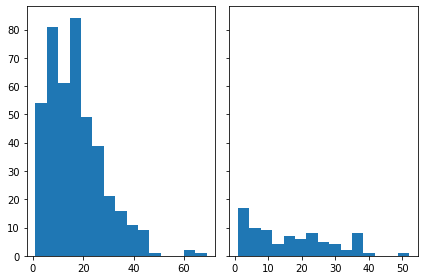

In [91]:
n_bins=15
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)
axs[0].hist(lengthsob, bins=n_bins)
axs[1].hist(lengthsny, bins=n_bins)
plt.show()

<A HREF="https://datascience.stackexchange.com/questions/23376/how-to-get-the-number-of-syllables-in-a-word">Counting syllables</A>

In [17]:
def syllables(word):
    #referred from stackoverflow.com/questions/14541303/count-the-number-of-syllables-in-a-word
    count = 0
    vowels = 'aeiouy'
    word = word.lower()
    if word[0] in vowels:
        count +=1
    for index in range(1,len(word)):
        if word[index] in vowels and word[index-1] not in vowels:
            count +=1
    if word.endswith('e'):
        count -= 1
    if word.endswith('le'):
        count += 1
    if count == 0:
        count += 1
    return count

<P>In a cmd/terminal window </P>
<P>>python</P>
<P>>>> import nltk</P>
<P>>>> nltk.download()</P>
<P>This opens a window from which you can download various corpora and dictionaries from NLTK</P>


In [19]:
import nltk
from nltk.corpus import cmudict
d = cmudict.dict()

In [20]:
def nsyl(word):
    try:
        return [len(list(y for y in x if y[-1].isdigit())) for x in d[word.lower()]]
    except KeyError:
        #if word not found in cmudict
        return syllables(word)

<A HREF="https://spacy.io/universe/project/spacy_syllables">Spacy Syllables</A>

In [ ]:
!pip install spacy_syllables

In [23]:
import spacy
from spacy_syllables import SpacySyllables

In [24]:
nlp = spacy.load("en_core_web_sm")
nlp.add_pipe("syllables", after="tagger")

assert nlp.pipe_names == ["tok2vec", "tagger", "syllables", "parser",  "attribute_ruler", "lemmatizer", "ner"]
doc = nlp(speeches[87])
data = [(token.text, token._.syllables, token._.syllables_count) for token in doc]
# punctuation returns None, skip those
[i[2] for i in data if i[2]!=None]

/home/muddy/.local/lib/python3.9/site-packages/spacy/util.py:877: UserWarning: [W095] Model 'en_core_web_sm' (3.3.0) was trained with spaCy v3.3 and may not be 100% compatible with the current version (3.4.2). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


[1,
 3,
 3,
 2,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 1,
 2,
 1,
 1,
 2,
 1,
 2,
 1,
 3,
 2,
 1,
 1,
 1,
 1,
 2,
 4,
 1,
 1,
 4,
 1,
 5,
 4,
 1,
 2,
 1,
 4,
 1,
 5,
 1,
 1,
 1,
 2,
 1,
 2,
 1,
 3,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 4,
 2,
 1,
 3,
 2,
 1,
 5,
 1,
 3,
 4,
 1,
 4,
 1,
 2,
 1,
 5,
 3,
 1,
 1,
 1,
 1,
 2,
 1,
 2,
 1,
 1,
 2,
 2,
 3,
 1,
 1,
 2,
 1,
 1,
 3,
 1,
 2,
 1,
 1,
 1,
 3,
 1,
 1,
 2,
 1,
 2,
 5,
 1,
 3,
 1,
 3,
 3,
 1,
 2,
 1,
 2,
 1,
 1,
 1,
 2,
 1,
 1,
 4,
 1,
 1,
 4,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 5,
 1,
 2,
 1,
 2,
 2,
 2,
 1,
 1,
 2,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 5,
 1,
 1,
 3,
 2,
 1,
 2,
 1,
 3,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 5,
 2,
 1,
 1,
 2,
 1,
 1,
 3,
 2,
 2,
 1,
 1,
 3,
 1,
 2,
 3,
 3,
 1,
 1,
 3,
 1,
 1,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 3,
 1,
 1,
 2,
 1,
 1,
 2,
 1,
 1,
 3,
 1,
 1,
 1,
 2,
 2,
 3,
 2,
 1,
 1,
 5,
 1,
 2,
 2,
 1,
 3,
 5,
 1,
 1,
 1,
 2,
 1,
 3,
 1,
 2,
 1,
 1,
 1,
 1,
 2,
 2,
 1,
 1,
 1,
 3,
 1,
 1,
 2,
 1,
 2,
 4,
 1,


In [25]:
data

[('Good', ['good'], 1),
 ('afternoon', ['af', 'ter', 'noon'], 3),
 (',', None, None),
 ('everybody', ['ev', 'ery', 'body'], 3),
 ('.', None, None),
 ('Before', ['be', 'fore'], 2),
 ('Jay', ['jay'], 1),
 ('takes', ['takes'], 1),
 ('some', ['some'], 1),
 ('of', ['of'], 1),
 ('your', ['your'], 1),
 ('questions', ['ques', 'tions'], 2),
 (',', None, None),
 ('I', ['i'], 1),
 ('wanted', ['want', 'ed'], 2),
 ('to', ['to'], 1),
 ('provide', ['pro', 'vide'], 2),
 ('a', ['a'], 1),
 ('brief', ['brief'], 1),
 ('update', ['up', 'date'], 2),
 ('on', ['on'], 1),
 ('our', ['our'], 1),
 ('efforts', ['ef', 'forts'], 2),
 ('to', ['to'], 1),
 ('address', ['ad', 'dress'], 2),
 ('the', ['the'], 1),
 ('ongoing', ['on', 'go', 'ing'], 3),
 ('crisis', ['cri', 'sis'], 2),
 ('in', ['in'], 1),
 ('Ukraine', ['ukraine'], 1),
 ('.', None, None),
 ('Since', ['since'], 1),
 ('the', ['the'], 1),
 ('Russian', ['rus', 'sian'], 2),
 ('intervention', ['in', 'ter', 'ven', 'tion'], 4),
 (',', None, None),
 ('we', ['we'], 1),


In [92]:
!pip install spacy-readability

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 16.2 MB/s eta 0:00:000:00:01m eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.2/209.2 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 15.3 MB/s eta 0:00:00 MB/s eta 0:00:01
  Attempting uninstall: srsly
    Found existing installation: srsly 2.4.3
    Uninstalling srsly-2.4.3:
      Successfully uninstalled srsly-2.4.3
  Attempting uninstall: catalogue
    Found existing installation: catalogue 2.0.7
    Uninstalling catalogue-2.0.7:
      Successfully uninstalled catalogue-2.0.7
  Attempting uninstall: thinc
    Found existing installation: thinc 8.1.5
    Uninstalling thinc-8.1.5:
      Successfully uninstalled thinc-8.1.5
  Attempting uninstall: spacy
    Found existing installation: spacy 3.4.2
    Uninstalling spacy-3.4.2:
 